In [1]:

import sys
stdout = sys.stdout

import matplotlib.pyplot as plt
from matplotlib.path import Path
import numpy as np
import os

import sys
sys.path.insert(0, "../Code/")
from base import load_encoder
from train_ae import train_ae
from explain_cs import explain, apply
from metrics import metrics


In [2]:
# Configure the data generation process and train the autoencoder

num_clusters = 4
input_dim = 4

def gen(n = 400):
    
    x = np.zeros((n, 4))
    
    for i in range(n):
        
        if np.random.uniform() < 0.5:
            x[i, 0] = 1.0 + np.random.normal(loc = 0.0, scale = 0.2)
            
        if np.random.uniform() < 0.5:
            x[i, 1] = 1.0 + np.random.normal(loc = 0.0, scale = 0.2)
            
        x[i, 2] = np.random.normal(loc = 0.0, scale = 0.5)
        
        x[i, 3] = x[i, 0] + np.random.normal(loc = 0.0, scale = 0.05)
        
    return x

x = gen()

os.system("rm -rf Model")

train_ae(x, encoder_shape = [20, 2], decoder_shape = [2, 20])


INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Synthetic/Mo

In [3]:
# Calculate the autoencoder's representation

def load_model(input_dim = input_dim, model_file = "/home/gregory/Desktop/ELDR/Synthetic/Model/model.cpkt"):
    return load_encoder(input_dim, model_file, encoder_shape = [20, 2])

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})



In [4]:
# Cluster Points

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = num_clusters).fit(data_rep)


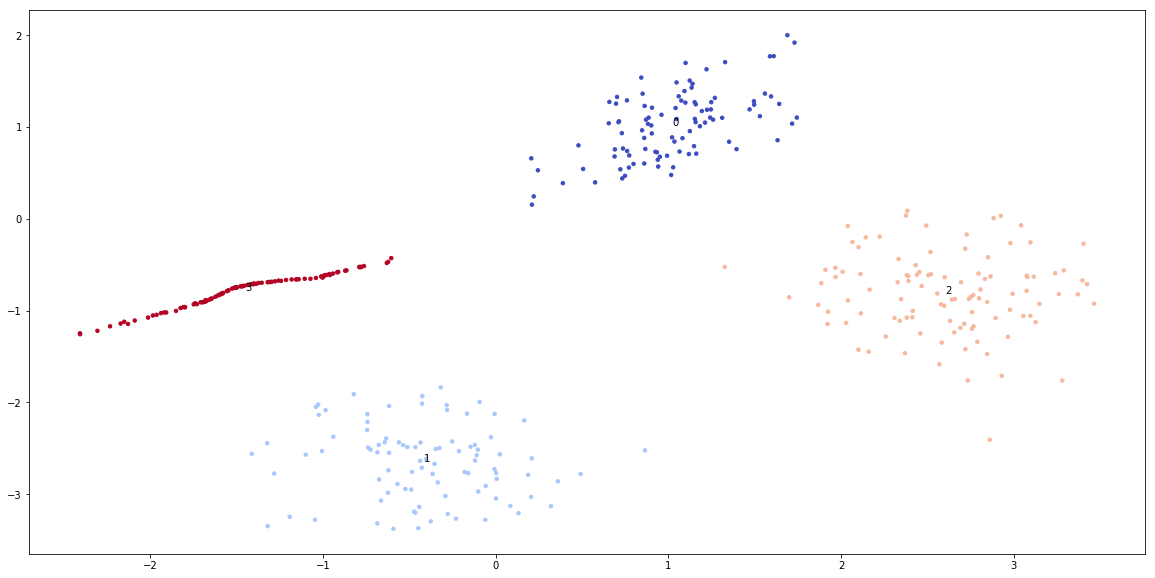

In [5]:
# Visualize the clusters in the learned representation

n = data_rep.shape[0]
cluster = -1.0 * np.ones((n))
indices = [[]] * num_clusters
centers = [[]] * num_clusters
means = [[]] * num_clusters
for i in range(num_clusters):
    indices[i] = []
    for j in range(n):
        if kmeans.labels_[j] == i:
            cluster[j] = i
            indices[i].append(j)
    centers[i] = np.mean(data_rep[indices[i], :], axis = 0)
    means[i] = np.mean(x[indices[i], :], axis = 0)
    
centers = np.array(centers)
means = np.array(means)

fig, ax = plt.subplots(figsize=(20, 10))
patches = []
    
plt.scatter(data_rep[:, 0], data_rep[:, 1], s = 12, c = cluster, cmap = plt.cm.coolwarm)

for i in range(num_clusters):
    plt.text(centers[i, 0], centers[i, 1], str(i))

plt.show()
plt.close()  

In [6]:
###
# Set epsilon for our metrics
###


epsilon = 0.5

if True:
    a, b = metrics(load_model, x, indices, np.zeros((num_clusters - 1, input_dim)), epsilon)

    d = np.diagonal(a)

    print(np.mean(d), np.min(d), np.max(d))



In [7]:
###
# Compute the cluster explanations
###


best_val = 0.0
for i in range(5):
    deltas = explain(load_model, means, centers, learning_rate = 0.01, consecutive_steps = 5, lambda_global = 1.0)
    a, b = metrics(load_model, x, indices, deltas, epsilon)
    
    val = np.mean(a)
    
    if val > best_val:
        best_val = val
        np.save("deltas.npy", deltas)
    
    os.system("rm -rf explanation")


In [8]:
def myplot(c1, c2, deltas):
    print("\nFrom ", c1, " to ", c2, "\n")
    print(a[c1, c2], b[c1, c2])
    
    if c1 == 0:
        d = deltas[c2 - 1]
    elif c2 == 0:
        d = -1.0 * deltas[c1 - 1]
    else:
        d = -1.0 * deltas[c1 - 1] + deltas[c2 - 1]
        
    apply(load_model, x, data_rep, indices, c1, np.reshape(d, (1, input_dim)), num_points = 20)

def myeval(deltas):
    
    a, b = metrics(load_model, x, indices, deltas, epsilon)
    
    plt.tight_layout()

    plt.subplot(1, 2, 1)

    plt.imshow(a, cmap = "RdYlGn", interpolation='nearest')
    plt.title("Correctness")

    plt.subplot(1, 2, 2)

    plt.imshow(b, cmap = "RdYlGn", interpolation='nearest')
    plt.title("Coverage")

    plt.show()
    plt.close()
    
    myplot(0, 1, deltas)
    myplot(0, 2, deltas)
    myplot(0, 3, deltas)
    

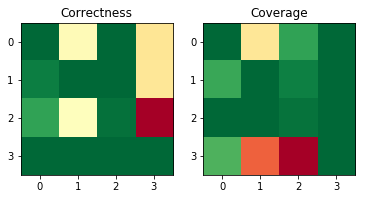

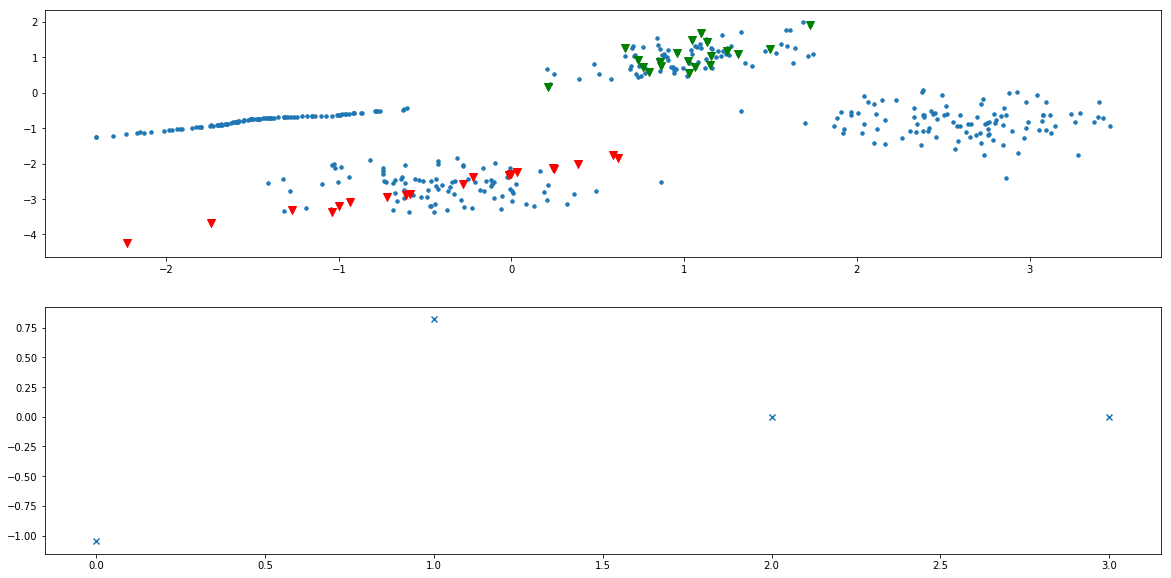

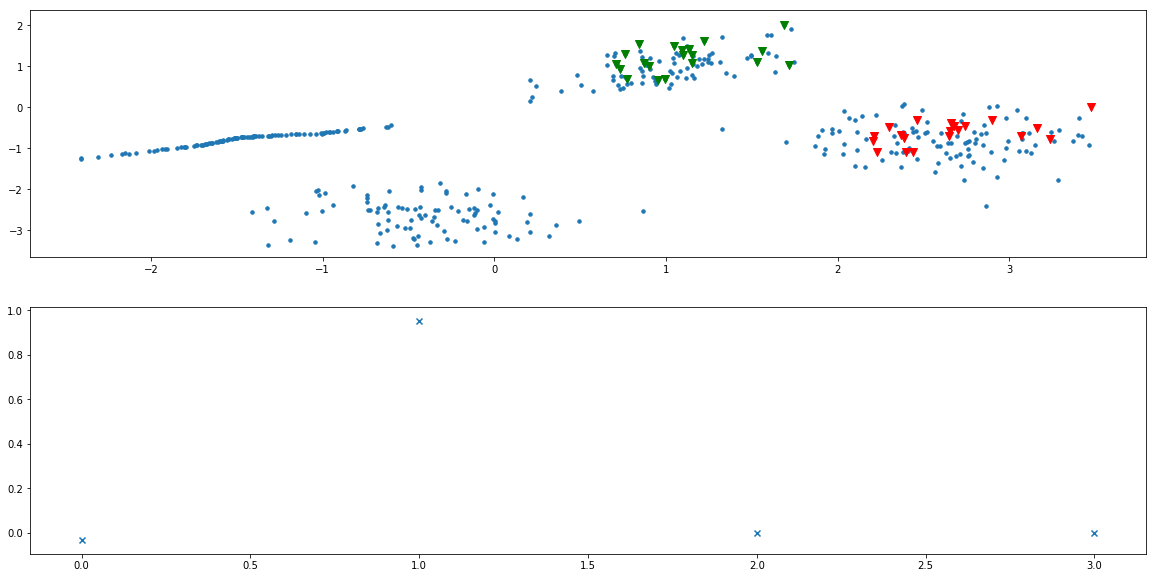

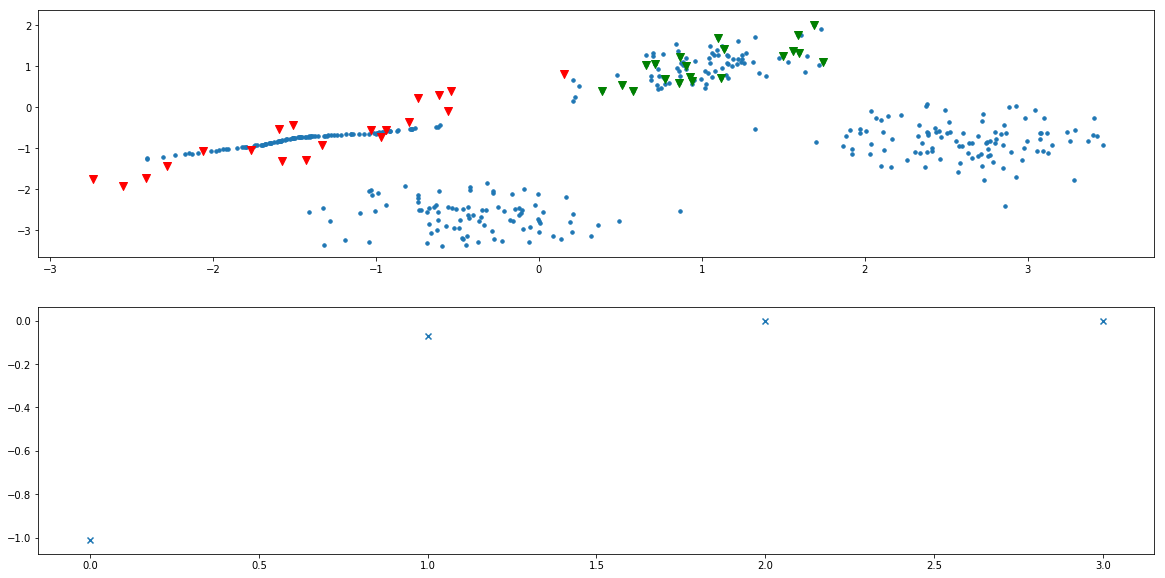

In [9]:
deltas = np.load("deltas.npy")

myeval(deltas)

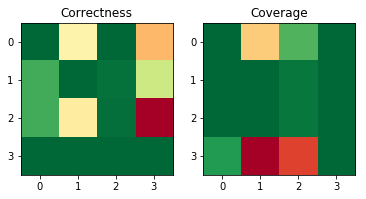

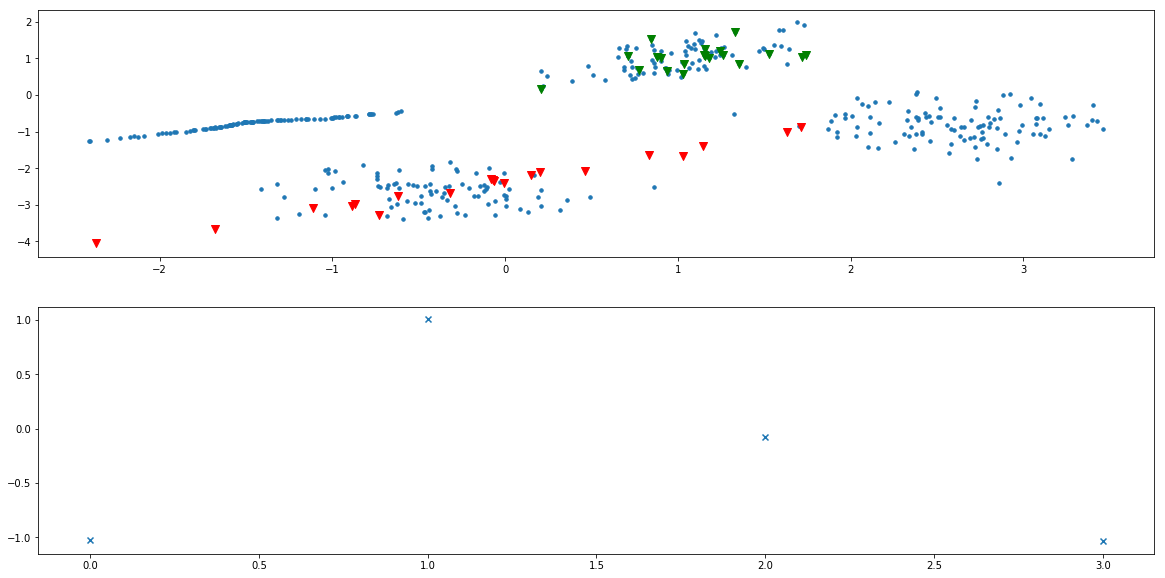

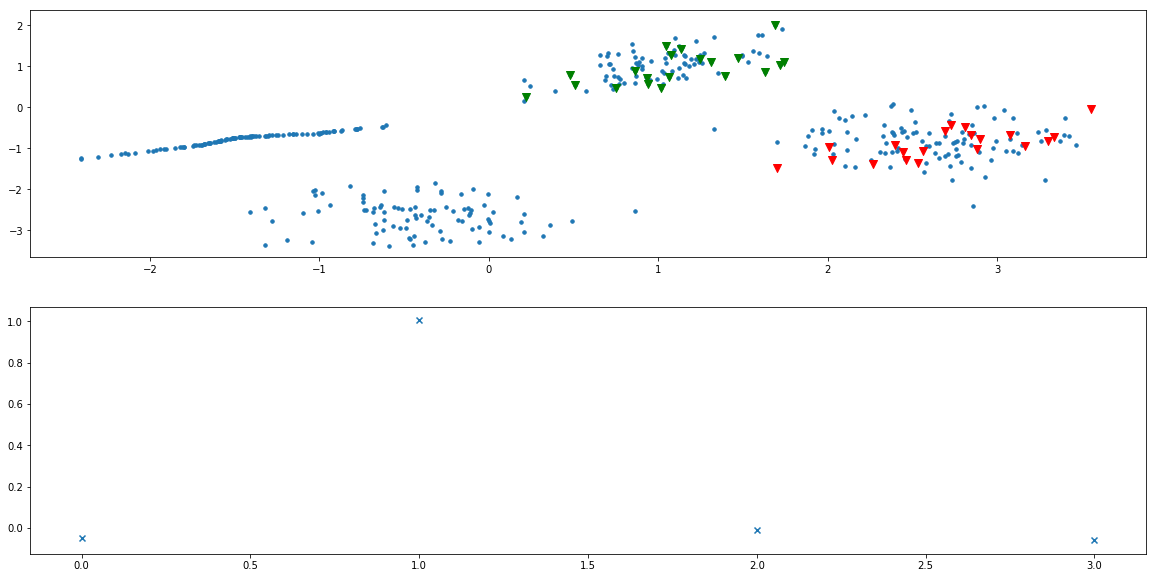

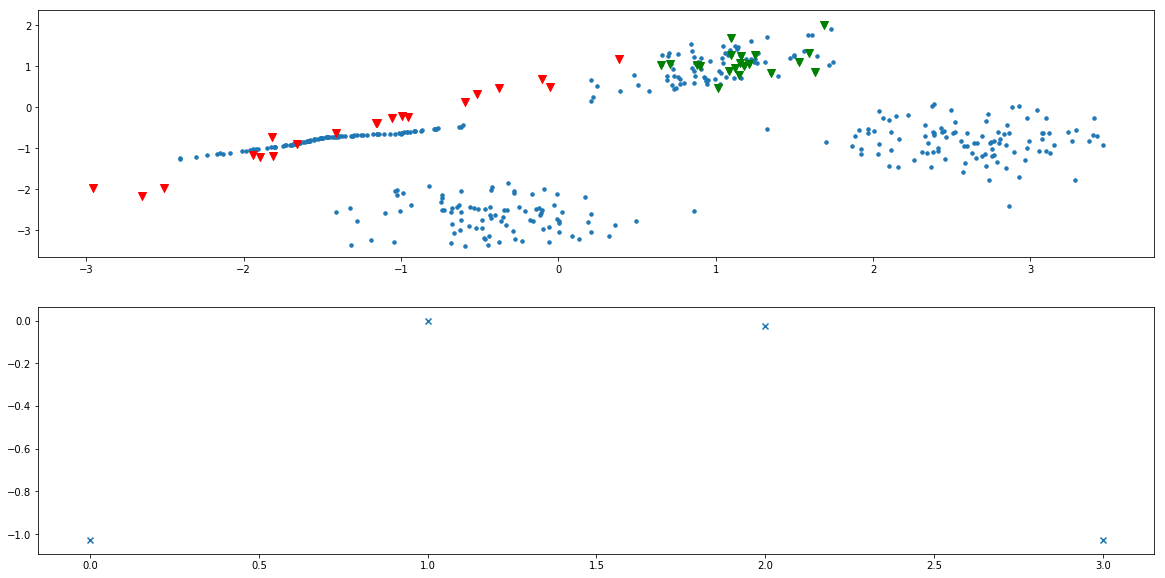

In [10]:
# Visualize the mean difference

exp_mean = np.zeros((num_clusters - 1, input_dim))
for i in range(num_clusters - 1):
    exp_mean[i, :] = means[i + 1] - means[0]
    
myeval(exp_mean)


